In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import urllib.request, urllib.parse, json
import time
import tempfile
from rdkit import Chem
import datetime
#import multiprocess as mp

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP +'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'

In [3]:
import openpyxl

In [4]:
df = pd.read_excel(raw_dir+'ICF_extractions_211223_wTIMES.xlsx', sheet_name = 'timesivt')

In [5]:
df['parent'] = df['Chemical name'].fillna(method = 'ffill')

/tmp/ipykernel_570672/3726619019.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['parent'] = df['Chemical name'].fillna(method = 'ffill')


In [6]:
df['Chemical name'].nunique()
df['Parent'] = df['Chemical name'].apply(lambda x: 'Parent' if pd.notnull((x)) else np.nan)

In [7]:
def smi_inchi(x):
    mol = Chem.MolFromSmiles(x)
    clean_smi = Chem.MolToSmiles(mol, isomericSmiles=False)
    clean_mol = Chem.MolFromSmiles(clean_smi)
    inchi =     Chem.MolToInchi(clean_mol)
    inchi_key = Chem.InchiToInchiKey(inchi)
    return inchi_key

In [8]:
newlst = []

for i, group in df.groupby('#'):
    subset = group[['parent', 'Parent']]
    #print(i, subset)
    for x, y, z in zip(enumerate(range(0, len(subset['parent']))), subset['parent'], subset['Parent']):
        if z == 'Parent':
            newlst.append(y)
        elif z != 'Parent':
            newlst.append(y+'_m_'+str(x[0]))

In [9]:
len(newlst)

6282

In [10]:
df['ID'] = newlst

In [11]:
inchi_keys = {}
errors = []
for k,v in zip(df['ID'], df['SMILES']):
    try:
        X = smi_inchi(v)
    except Exception as error:
        errors.append(error)
    else:
        inchi_keys[k] = X

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefined stereo

[17:58:45] WARNING: Omitted undefi

In [12]:
len(inchi_keys)

6270

In [13]:
df_inchi = pd.DataFrame(inchi_keys.items(), columns = ['ID', 'INCHI_KEY'])

In [14]:
df2 = pd.merge(df, df_inchi, on = 'ID', how = 'left')

In [15]:
df2.head()

,#,ID of metabolite,Level of generation,Predecessor ID,CAS,Chemical name,SMILES,Observed map/metabolite,Transformation name,Transformation No,...,Transformation probability,Used probability,Enzyme(s),Quantity of metabolite,Total quantity of metabolite,Number of repetitions,parent,Parent,ID,INCHI_KEY
0,1,1,0,-,NaN,DTXSID4020298,Clc1ccccc1,NaN,NaN,NaN,...,NaN,NaN,NaN,0.003375,0.003375,1,DTXSID4020298,Parent,DTXSID4020298,MVPPADPHJFYWMZ-UHFFFAOYSA-N
1,1,2,1,1,NaN,NaN,Oc1ccccc1Cl,NaN,Aromatic C-Hydroxylation|Haloarene Aromatic C-...,322.0,...,0.85,0.3322,[E] 1.14.14.1 (CYP1A1;CYP2B1),0.004983,0.004983,1,DTXSID4020298,NaN,DTXSID4020298_m_1,ISPYQTSUDJAMAB-UHFFFAOYSA-N
2,1,5,2,2,NaN,NaN,Oc1ccc(O)cc1Cl,NaN,Aromatic C-Hydroxylation|Phenol C-Hydroxylation,216.0,...,0.90,0.5066,1.14.14.1 (CYP1A1;CYP1A2); 1.14.14.1 (CYP2B1;C...,0.082460,0.082460,1,DTXSID4020298,NaN,DTXSID4020298_m_2,AJPXTSMULZANCB-UHFFFAOYSA-N
3,1,7,3,5,NaN,NaN,OC1C(O)C(O)C(C(O)=O)OC1Oc1ccc(O)c(Cl)c1,NaN,"O-Glucuronidation|Alcohol, Phenol, Carboxylic ...",510.0,...,0.30,0.2550,2.4.1.17; 2.4.1.17 (UGT2B1;UGT2B12),0.042910,0.042910,1,DTXSID4020298,NaN,DTXSID4020298_m_3,WROXWNLBXJZRNE-UHFFFAOYSA-N
4,1,8,3,5,NaN,NaN,OC1C(O)C(O)C(C(O)=O)OC1Oc1ccc(O)cc1Cl,NaN,"O-Glucuronidation|Alcohol, Phenol, Carboxylic ...",510.0,...,0.30,0.2550,2.4.1.17; 2.4.1.17 (UGT2B1;UGT2B12),0.042910,0.042910,1,DTXSID4020298,NaN,DTXSID4020298_m_4,XXVBOGQUSBWILV-UHFFFAOYSA-N


In [16]:
df2[df2['INCHI_KEY'].isnull()]

,#,ID of metabolite,Level of generation,Predecessor ID,CAS,Chemical name,SMILES,Observed map/metabolite,Transformation name,Transformation No,...,Transformation probability,Used probability,Enzyme(s),Quantity of metabolite,Total quantity of metabolite,Number of repetitions,parent,Parent,ID,INCHI_KEY
4565,307,1,0,-,NaN,DTXSID5038913,CCN(CC)c1ccc(C(=C2C=CC(=[N+](.[Cl-])(CC)CC)C=C...,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00000,0.0000,1,DTXSID5038913,Parent,DTXSID5038913,NaN
5036,343,3,0,1,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,1.00000,1.0000,1,DTXSID6029626,NaN,DTXSID6029626_m_2,NaN
5040,344,5,0,2,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,0.50000,0.5000,1,DTXSID2029745,NaN,DTXSID2029745_m_3,NaN
5165,356,1,0,-,NaN,DTXSID5027774,O=C1CN2CCN(CC(=O)[O-].[Na+])CC(=O)[O-].[Fe+3](...,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00000,0.0000,1,DTXSID5027774,Parent,DTXSID5027774,NaN
5181,358,1,0,-,NaN,DTXSID7029742,OCCN1CCN2CC(=O)[O-].[Fe+3](.[O-]C(=O)C1).[O-]C...,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00000,0.0000,1,DTXSID7029742,Parent,DTXSID7029742,NaN
5206,361,1,0,-,NaN,DTXSID9027815,[N+].[O-]C(=O)CN1CCN2CC(=O)[O-].[Fe+3](.[O-]C(...,NaN,NaN,NaN,...,NaN,NaN,NaN,0.00000,0.0000,1,DTXSID9027815,Parent,DTXSID9027815,NaN
5269,367,24,0,2,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,0.04762,0.2381,5,DTXSID00889574,NaN,DTXSID00889574_m_8,NaN
5270,367,25,0,2,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,0.04762,0.2381,5,DTXSID00889574,NaN,DTXSID00889574_m_9,NaN
5271,367,26,0,2,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,0.04762,0.2381,5,DTXSID00889574,NaN,DTXSID00889574_m_10,NaN
5272,367,27,0,2,NaN,NaN,OK,NaN,External Hydrolysis,568.0,...,1.0,1.0,NaN,0.04762,0.2381,5,DTXSID00889574,NaN,DTXSID00889574_m_11,NaN


In [17]:
df2['INCHI-KEY'] = df2[['INCHI_KEY', 'SMILES']].apply(lambda x: x[0] if pd.notnull((x[0])) else x[1], axis = 1)

/tmp/ipykernel_570672/933535847.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df2['INCHI-KEY'] = df2[['INCHI_KEY', 'SMILES']].apply(lambda x: x[0] if pd.notnull((x[0])) else x[1], axis = 1)


In [18]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6282 entries, 0 to 6281
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   #                                 6282 non-null   int64  
 1   ID of metabolite                  6282 non-null   int64  
 2   Level of generation               6282 non-null   int64  
 3   Predecessor ID                    6282 non-null   object 
 4   CAS                               0 non-null      float64
 5   Chemical name                     468 non-null    object 
 6   SMILES                            6282 non-null   object 
 7   Observed map/metabolite           196 non-null    object 
 8   Transformation name               5814 non-null   object 
 9   Transformation No                 5814 non-null   float64
 10  Transformation ID                 5814 non-null   float64
 11  Transformation probability group  5814 non-null   float64
 12  Transf

In [19]:
df4 = df2[['parent','ID of metabolite','Predecessor ID','INCHI-KEY','Transformation name', 'SMILES']]

In [20]:
from rdkit import Chem
from rdkit.Chem import AllChem

In [21]:
df4[df4['parent'] == 'DTXSID0020151']

,parent,ID of metabolite,Predecessor ID,INCHI-KEY,Transformation name,SMILES
815,DTXSID0020151,1,-,QUKGYYKBILRGFE-UHFFFAOYSA-N,NaN,CC(=O)OCc1ccccc1
816,DTXSID0020151,2,1,WVDDGKGOMKODPV-UHFFFAOYSA-N,Hydrolysis|Ester Hydrolysis|Carboxylic Ester H...,OCc1ccccc1
817,DTXSID0020151,4,2,HUMNYLRZRPPJDN-UHFFFAOYSA-N,Aliphatic C-Oxidation|Primary Alcohol Oxidation,O=Cc1ccccc1
818,DTXSID0020151,5,4,WPYMKLBDIGXBTP-UHFFFAOYSA-N,Aliphatic C-Oxidation|Aldehyde Oxidation,OC(=O)c1ccccc1
819,DTXSID0020151,3,1,QTBSBXVTEAMEQO-UHFFFAOYSA-N,Hydrolysis|Ester Hydrolysis|Carboxylic Ester H...,CC(O)=O


In [22]:
metab_dict = {k: Chem.MolFromSmiles(v) for k,v in zip(df4['INCHI-KEY'], df4['SMILES'])}

[17:59:15] SMILES Parse Error: syntax error while parsing: CCN(CC)c1ccc(C(=C2C=CC(=[N+](.[Cl-])(CC)CC)C=C2)c2ccc(N(CC)CC)cc2)cc1
[17:59:15] SMILES Parse Error: Failed parsing SMILES 'CCN(CC)c1ccc(C(=C2C=CC(=[N+](.[Cl-])(CC)CC)C=C2)c2ccc(N(CC)CC)cc2)cc1' for input: 'CCN(CC)c1ccc(C(=C2C=CC(=[N+](.[Cl-])(CC)CC)C=C2)c2ccc(N(CC)CC)cc2)cc1'
[17:59:15] SMILES Parse Error: syntax error while parsing: OK
[17:59:15] SMILES Parse Error: Failed parsing SMILES 'OK' for input: 'OK'
[17:59:15] SMILES Parse Error: syntax error while parsing: OK
[17:59:15] SMILES Parse Error: Failed parsing SMILES 'OK' for input: 'OK'
[17:59:15] SMILES Parse Error: syntax error while parsing: O=C1CN2CCN(CC(=O)[O-].[Na+])CC(=O)[O-].[Fe+3](.[O-]1).[O-]C(=O)C2
[17:59:15] SMILES Parse Error: Failed parsing SMILES 'O=C1CN2CCN(CC(=O)[O-].[Na+])CC(=O)[O-].[Fe+3](.[O-]1).[O-]C(=O)C2' for input: 'O=C1CN2CCN(CC(=O)[O-].[Na+])CC(=O)[O-].[Fe+3](.[O-]1).[O-]C(=O)C2'
[17:59:15] SMILES Parse Error: syntax error while parsing: OCCN1CC

In [23]:
metab_dict = {k:v for k,v in metab_dict.items() if v is not None}

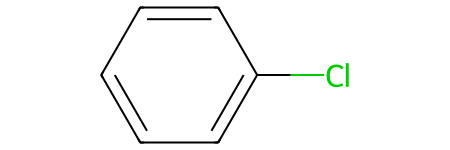

In [24]:
metab_dict['MVPPADPHJFYWMZ-UHFFFAOYSA-N']

In [25]:

fpgen = AllChem.GetMorganGenerator(radius=3, fpSize=1024)


In [26]:
fp_dict = {}
for k,v in metab_dict.items():
    fp_dict[k] = np.array(AllChem.GetMorganFingerprintAsBitVect(v,3,1024))

In [27]:
#fp_dict

In [28]:
import networkx as nx

In [29]:
def createGraphs(csv):
    metabolites = []
    chemicals = []
    reactions = []
    rows = csv.to_dict(orient='records')
    for row in rows:
        metabolites.append(row['INCHI-KEY'])
        chemicals.append(row['parent'])
        reactions.append(row['Transformation name'])

    chemicals = np.unique(chemicals)
    metabolites = np.unique(metabolites)
    reactions = np.unique(reactions)

    frames = []
    for chemical in chemicals:
        newFrame = pd.DataFrame()
        name = chemical
        for row in rows:
            if row['parent'] == name:
                newFrame = pd.concat([newFrame, pd.DataFrame([row])],ignore_index=True)
        frames.append(newFrame)

    graphs = []
    for chemical in frames:
        newGraph = nx.DiGraph()
        newGraph.name = chemical['parent'][0]
        nodeID = 0
        for i in range(len(chemical)):
            if i == 0:
                newGraph.add_node(nodeID,smile=chemical['INCHI-KEY'][i])
                nodeID += 1
            else:
                newGraph.add_node(nodeID,smile=chemical['INCHI-KEY'][i])
                newGraph.add_edge((int(chemical['Predecessor ID'][i])-1),int(nodeID),reaction=chemical['Transformation name'][i])
                nodeID += 1
        graphs.append(newGraph)
    print(str(len(graphs)) + ' metabolic graph objects created.')
    print(str(len(metabolites)) + ' unique metabolites generated in predictions.')
    print(str(len(reactions)) + ' unique reactions generating metabolites in predictions.')
    return graphs,metabolites 


In [30]:
a,b = createGraphs(df4)

468 metabolic graph objects created.
3257 unique metabolites generated in predictions.
107 unique reactions generating metabolites in predictions.


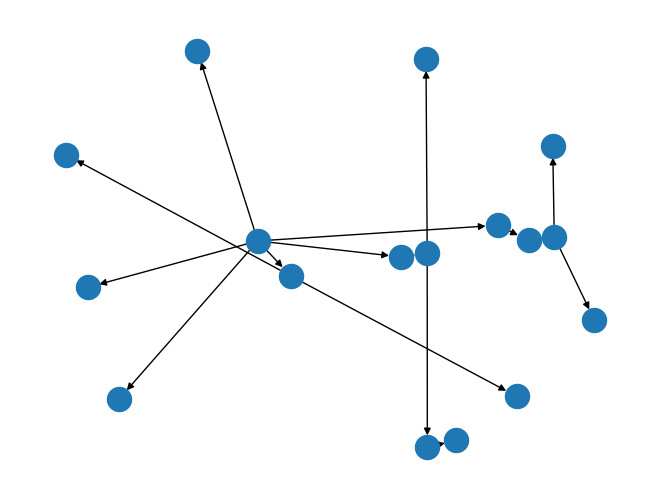

In [31]:
nx.draw(a[2])

In [32]:
graphNames = []
for graph in a:
    graphNames.append(graph.name)


In [33]:
graph_dict = {}
for graph in a:
    graph_dict[graph.name] = graph

In [34]:
len(graph_dict)

468

In [35]:
graph_dict['DTXSID0020151']

In [36]:
reactions = df2[df2['Transformation name'].notnull()]['Transformation name'].unique().tolist()

In [37]:
len(reactions)

106

In [38]:
#reactions

In [39]:
reaction_dict = {}
for idx in range(len(reactions)):
    vec = np.zeros(len(reactions))
    vec[idx] = 1
    reaction_dict[reactions[idx]] = vec


In [40]:
#reaction_dict

In [41]:
balanced_df = pd.read_csv(interim_dir+'balanced_df_icf_140424.csv', index_col = [0])
balanced_df

,Target,Analogue,Label,analogue_smi,target_smi,analogue_mol,target_mol,fps_target,fps_analogue,tanimoto,Euclidean
94147,DTXSID60626563,DTXSID6044068,1,CC1=C(C=C(C=C1N)[N+]([O-])=O)[N+]([O-])=O,CCCCCCC1=CC(=C(O)C(=C1)C(C)(C)C)C(C)(C)C,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee3c0>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311040>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.064516,7.615773
20729,DTXSID7027255,DTXSID1024621,1,COCCOCCOC,C\C=C\C,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee430>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311120>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.058824,4.000000
136459,DTXSID0074716,DTXSID9026714,0,CCCC(C)CO,CCCC(CO)CCC,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee2e0>,<rdkit.Chem.rdchem.Mol object at 0x7905c53110b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.454545,3.464102
26548,DTXSID10497003,DTXSID0044571,0,CC(C)C1=CC=CC(O)=C1,CC(C)CC1=CC(O)=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee510>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.394737,4.795832
12767,DTXSID6022000,DTXSID8020044,1,OCC=C,NCCO,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee580>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311200>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.214286,3.316625
...,...,...,...,...,...,...,...,...,...,...,...
122681,DTXSID3021982,DTXSID9021764,1,CC(O)CN,CCCCOC(C)=O,<rdkit.Chem.rdchem.Mol object at 0x7905c5310dd0>,<rdkit.Chem.rdchem.Mol object at 0x7905c52a7b30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.142857,4.898979
133571,DTXSID60193725,DTXSID9046526,1,CCOC(=O)C1=CN=CC=C1,CCCCC1=CC(O)=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x7905c5310e40>,<rdkit.Chem.rdchem.Mol object at 0x7905c52a7ba0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.140351,7.000000
79999,DTXSID2028985,DTXSID0020440,1,CC(OC1=C(Cl)C=C(Cl)C=C1)C(O)=O,CC(C)(C1=CC=CC=C1)C1=CC(N2N=C3C=CC=CC3=N2)=C(O...,<rdkit.Chem.rdchem.Mol object at 0x7905c5310eb0>,<rdkit.Chem.rdchem.Mol object at 0x7905c52a7c10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.098765,8.544004
20173,DTXSID00285658,DTXSID0022480,1,CCC1=CC=CC(O)=C1,CCCCCCCCCCCC(=O)OCCC1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x7905c5310f20>,<rdkit.Chem.rdchem.Mol object at 0x7905c52a7c80>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.186441,6.928203


In [42]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [43]:
#fp_dict

In [44]:
 nds = nx.get_node_attributes(graph_dict['DTXSID0020151'], 'smile')

In [45]:
nds

{0: 'QUKGYYKBILRGFE-UHFFFAOYSA-N',
 1: 'WVDDGKGOMKODPV-UHFFFAOYSA-N',
 2: 'HUMNYLRZRPPJDN-UHFFFAOYSA-N',
 3: 'WPYMKLBDIGXBTP-UHFFFAOYSA-N',
 4: 'QTBSBXVTEAMEQO-UHFFFAOYSA-N'}

In [46]:
egd = nx.get_edge_attributes(graph_dict['DTXSID0020151'],'reaction')

In [47]:
for edge,reaction in egd.items():
    print(([edge[0], edge[1]]))

[0, 1]
[0, 4]
[1, 2]
[3, 3]


In [48]:
f = []
for idx in range(len(nds)):
    f.append(fp_dict[nds[idx]])
x = np.stack(f)
print(x)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [49]:
def update_graph(graph, fp, rxn):
    features = []
    edge_features,edge_tensors = [],[]
    nodes = nx.get_node_attributes(graph, 'smile')
    for idx in range(len(nodes)):
        features.append(fp[nodes[idx]])
    
    x = np.stack(features)
    
    edges = nx.get_edge_attributes(graph,'reaction')
    
    for edge,reaction in edges.items():
        edge_tensors.append(list(edge))
        edge_features.append(rxn[reaction])
    edge_tensors = torch.tensor(edge_tensors,dtype=torch.long)
    edge_features = torch.tensor(edge_features)
    data = Data(x=torch.tensor(x,dtype=torch.float),edge_index=edge_tensors.t().contiguous(),edge_attr=edge_features)
    return data

In [50]:
update_graph(graph_dict['DTXSID0020151'], fp_dict, reaction_dict)

/tmp/ipykernel_570672/3275463935.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  edge_features = torch.tensor(edge_features)


Data(x=[5, 1024], edge_index=[2, 4], edge_attr=[4, 106])

In [51]:
pytorch_dict = {}
errors = []
for k, graph in graph_dict.items():
    try:
        a = update_graph(graph, fp_dict, reaction_dict)
    except Exception as error:
        errors.append(error)
    pytorch_dict[k] = a

In [52]:
len(pytorch_dict)

468

In [53]:
#df3

In [54]:
from torch.utils.data import Dataset, DataLoader

In [55]:
class GraphData(Dataset):
    def __init__(self, df):
        """
        GraphData class inheriting from the Dataset class in PyTorch.

        Parameters
        ----------
    
        node_vec_len : int
            Node vector length of molecular graphs
        max_atoms : int
            Maximum number of atoms in molecular graphs
        """
        self.df = df

        # Create lists
        #self.indices = df.index.to_list()
        #self.smiles = df["smiles"].to_list()
        #self.outputs = df["measured log solubility in mols per litre"].to_list()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        """
        Returns node matrix, adjacency matrix, output, and SMILES string of
        molecule.

        Parameters
        ----------
        i : int
            Dataset index

        Returns
        -------
        node_mat : torch.Tensor with dimension (max_atoms,node_vec_len)
            Node matrix
        adj_mat: torch.Tensor with dimension (max_atoms,max_atoms)
            Adjacency matrix
        output : torch.Tensor with dimension n_outputs
            Output vector
        smile : str
            SMILES string of molecule
        """
        
        row = self.df.iloc[idx]
        target = pytorch_dict[row['Target']]
        analogue =pytorch_dict[row['Analogue']]
        


        # Get output
        label = torch.tensor(row['Label'], dtype=torch.long)

        return target, analogue, label

In [56]:
balanced_df

,Target,Analogue,Label,analogue_smi,target_smi,analogue_mol,target_mol,fps_target,fps_analogue,tanimoto,Euclidean
94147,DTXSID60626563,DTXSID6044068,1,CC1=C(C=C(C=C1N)[N+]([O-])=O)[N+]([O-])=O,CCCCCCC1=CC(=C(O)C(=C1)C(C)(C)C)C(C)(C)C,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee3c0>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311040>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.064516,7.615773
20729,DTXSID7027255,DTXSID1024621,1,COCCOCCOC,C\C=C\C,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee430>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311120>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.058824,4.000000
136459,DTXSID0074716,DTXSID9026714,0,CCCC(C)CO,CCCC(CO)CCC,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee2e0>,<rdkit.Chem.rdchem.Mol object at 0x7905c53110b0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.454545,3.464102
26548,DTXSID10497003,DTXSID0044571,0,CC(C)C1=CC=CC(O)=C1,CC(C)CC1=CC(O)=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee510>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311190>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.394737,4.795832
12767,DTXSID6022000,DTXSID8020044,1,OCC=C,NCCO,<rdkit.Chem.rdchem.Mol object at 0x7905c53ee580>,<rdkit.Chem.rdchem.Mol object at 0x7905c5311200>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.214286,3.316625
...,...,...,...,...,...,...,...,...,...,...,...
122681,DTXSID3021982,DTXSID9021764,1,CC(O)CN,CCCCOC(C)=O,<rdkit.Chem.rdchem.Mol object at 0x7905c5310dd0>,<rdkit.Chem.rdchem.Mol object at 0x7905c52a7b30>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.142857,4.898979
133571,DTXSID60193725,DTXSID9046526,1,CCOC(=O)C1=CN=CC=C1,CCCCC1=CC(O)=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x7905c5310e40>,<rdkit.Chem.rdchem.Mol object at 0x7905c52a7ba0>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.140351,7.000000
79999,DTXSID2028985,DTXSID0020440,1,CC(OC1=C(Cl)C=C(Cl)C=C1)C(O)=O,CC(C)(C1=CC=CC=C1)C1=CC(N2N=C3C=CC=CC3=N2)=C(O...,<rdkit.Chem.rdchem.Mol object at 0x7905c5310eb0>,<rdkit.Chem.rdchem.Mol object at 0x7905c52a7c10>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.098765,8.544004
20173,DTXSID00285658,DTXSID0022480,1,CCC1=CC=CC(O)=C1,CCCCCCCCCCCC(=O)OCCC1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x7905c5310f20>,<rdkit.Chem.rdchem.Mol object at 0x7905c52a7c80>,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,0.186441,6.928203


In [57]:
from sklearn.model_selection import train_test_split
#from kennard_stone import train_test_split

from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader

In [58]:
X_train, X_test, y_train, y_test  = train_test_split(balanced_df[['Target', 	'Analogue','target_smi', 'analogue_smi', 'Label','tanimoto', ]], balanced_df['Label'], stratify = balanced_df['Label'], random_state = 42,test_size=0.2)

In [59]:
X_train.shape

(4344, 6)

In [60]:
from torch_geometric.utils import smiles as pygsmi
import torch
import torch_geometric
import torch.nn.functional as F
from torch.nn import Linear
from torch.nn import BatchNorm1d
from torch.utils.data import Dataset
from torch_geometric.nn import GCNConv
from torch_geometric.nn import ChebConv
from torch_geometric.nn import global_add_pool, global_mean_pool
from torch_geometric.loader import DataLoader

In [61]:
train_data = GraphData(X_train)

In [62]:
test_data = GraphData(X_test)

In [63]:
test_data[0]

(Data(x=[10, 1024], edge_index=[2, 9], edge_attr=[9, 106]),
 Data(x=[12, 1024], edge_index=[2, 11], edge_attr=[11, 106]),
 tensor(1))

In [64]:
test_data[0][0].num_features

1024

In [65]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool

In [66]:
from torch_geometric.nn import GATv2Conv,SAGEConv
from torch_geometric.nn import GCNConv,Linear,global_mean_pool

# define GCN model
class GCN(torch.nn.Module):

    def __init__(self):

        super(GCN,self).__init__()
        torch.manual_seed(12345)

        # define convolutional layers
        self.conv1 = GATv2Conv(1024,512)
        self.conv2 = GATv2Conv(512,256)
        # self.conv3 = GATv2Conv(256,128)
        # self.conv1 = SAGEConv(1024,512)
        # self.conv2 = SAGEConv(512,256)
        # self.conv3 = SAGEConv(256,128)

        # define linear layers
        self.lin1 = Linear(256,128)
        #self.lin2 = Linear(128,2)
        # self.lin3 = Linear(64,2)

    # define forward pass
    def forward_once(self,data, batch=torch.tensor([0])):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x,edge_index)
        x = x.relu()
        x = self.conv2(x,edge_index)
        #x = x.relu()
        # x = self.conv3(x,edge_index)
        # x = x.relu()

        # pull embedding from readout layer before continuing to linear layers
        embedding = global_mean_pool(x,batch)
        x = global_mean_pool(x,batch)
        
        x = self.lin1(x)
        #x = x.relu()
        #x = self.lin2(x)
        
        return x
    
    def forward(self, input1, input2):
       
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2
    

In [67]:
model = GCN()

In [68]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Euclidean distance between the embeddings
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

        # Contrastive loss formula
        contrastive_loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return contrastive_loss

In [69]:
criterion = ContrastiveLoss()
#optimizer = torch.optim.SGD(params=gin.parameters(), lr=0.005)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [78]:
for data in test_data:
    x, y, z = data
    if len(y) ==0:
        print(y)

In [79]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=True, drop_last=True)

In [80]:
test_loader = DataLoader(test_data, batch_size=1,shuffle=False, drop_last = True)

In [85]:
for batch  in test_loader:
    print(batch)
    break


[DataBatch(x=[10, 1024], edge_index=[2, 9], edge_attr=[9, 106], batch=[10], ptr=[2]), DataBatch(x=[12, 1024], edge_index=[2, 11], edge_attr=[11, 106], batch=[12], ptr=[2]), tensor([1])]


In [86]:
for data in test_loader:
    a, b, c = data
    print(a,b,c)
    break

DataBatch(x=[10, 1024], edge_index=[2, 9], edge_attr=[9, 106], batch=[10], ptr=[2]) DataBatch(x=[12, 1024], edge_index=[2, 11], edge_attr=[11, 106], batch=[12], ptr=[2]) tensor([1])


In [87]:
import matplotlib.pyplot as plt

In [88]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [89]:
def train_siamese_network(model, train_loader, optimizer, criterion, num_epochs=10):
    
    loss_lst=[]
    counter=[]
    iteration_number = 0
    for epoch in range(1, num_epochs):
        total_loss = 0.0
        model.train()
        for  i, data in enumerate(train_loader,0):
            input1, input2, label = data
            optimizer.zero_grad()
            output1, output2 = model(input1, input2)
            loss = criterion(output1, output2, label)
            #print(loss)
            #total_loss += loss /len(train_loader)
            loss.backward()
            optimizer.step()
        print("Epoch {}\ Current loss {}".format(epoch,loss.item()))
        iteration_number += 10
        counter.append(iteration_number)
        loss_lst.append(loss.item())
        
    show_plot(counter, loss_lst)
        
    return model

In [90]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from itertools import chain

In [91]:
#for i, data in enumerate(test_loader):
#    print(data)

In [97]:
def test_network(model, test_loader, threshold=5):
    true_labels = np.empty((0,))
    predicted_labels = np.empty((0,))
    euclidean = np.empty((0,))
    
    model.eval()
    
    with torch.no_grad():
        for i, data in enumerate(test_loader,0):
            # Unpack data
            input1, input2, label = data
            #print(label)
            try:
                output1, output2 = model(input1, input2)
                #print(output1, output2)
                euclidean_distance = F.pairwise_distance(output1, output2)
                predictions = (euclidean_distance > threshold).float()


                true_labels = np.append(true_labels, label.view(-1).cpu().numpy())
                predicted_labels = np.append(predicted_labels, predictions.view(-1).cpu().numpy())
                euclidean = np.append(euclidean, euclidean_distance.view(-1).cpu().numpy())
            except Exception as error:
                print(error)
            

            #print(input1['smiles'], input2['smiles'], label, euclidean_distance.item())
            
           

    
    

        return true_labels, predicted_labels, euclidean

In [98]:
a, b, c =test_network(model, test_loader, threshold = 1)

index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with size 0
index 0 is out of bounds for dimension 0 with 

In [101]:
len(a), len(b), len(c)

(1026, 1026, 1026)

(array([ 18.,  53., 254., 309., 225., 109.,  41.,  11.,   0.,   6.]),
 array([1.13137075e-05, 2.21291735e-01, 4.42572156e-01, 6.63852577e-01,
        8.85132997e-01, 1.10641342e+00, 1.32769384e+00, 1.54897426e+00,
        1.77025468e+00, 1.99153510e+00, 2.21281552e+00]),
 <BarContainer object of 10 artists>)

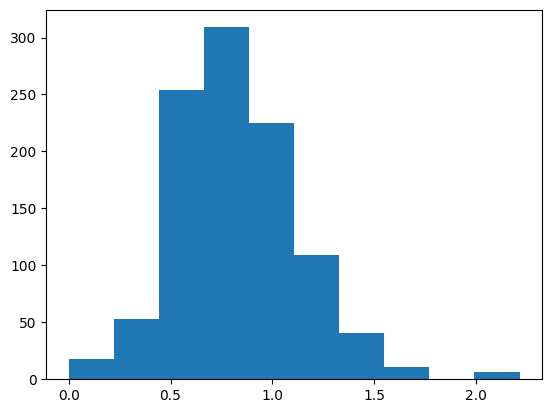

In [103]:
plt.hist(c)

In [104]:
from sklearn.metrics import balanced_accuracy_score,accuracy_score,f1_score, confusion_matrix, recall_score, precision_score

In [105]:
accuracy_score(a, b)

0.5994152046783626

In [106]:
precision = precision_score(a, b)
recall = recall_score(a, b)
f1 = f1_score(a, b)
cm = confusion_matrix(a,b)

In [107]:
cm

array([[446,  79],
       [332, 169]])

In [108]:
print(precision, recall, f1)

0.6814516129032258 0.3373253493013972 0.45126835781041386


Epoch 1\ Current loss 2998.1025390625
Epoch 2\ Current loss 774.6454467773438
Epoch 3\ Current loss 1134.1575927734375
Epoch 4\ Current loss 629.0713500976562
Epoch 5\ Current loss 546.3480224609375
Epoch 6\ Current loss 325.6640319824219
Epoch 7\ Current loss 254.8243408203125
Epoch 8\ Current loss 190.10546875
Epoch 9\ Current loss 104.83939361572266
Epoch 10\ Current loss 103.69122314453125
Epoch 11\ Current loss 94.2240982055664
Epoch 12\ Current loss 80.60100555419922
Epoch 13\ Current loss 87.29927062988281
Epoch 14\ Current loss 52.18352508544922
Epoch 15\ Current loss 55.0531005859375
Epoch 16\ Current loss 47.129268646240234
Epoch 17\ Current loss 36.67657470703125
Epoch 18\ Current loss 36.03456115722656
Epoch 19\ Current loss 31.400747299194336


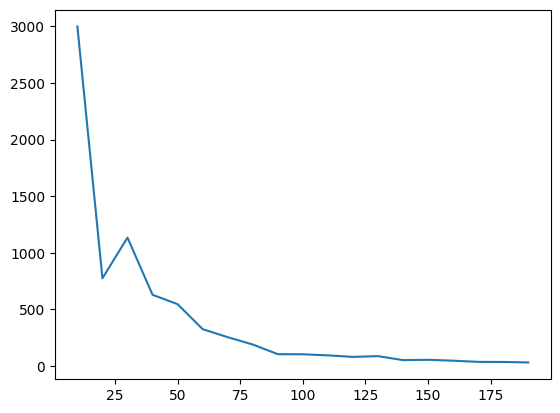

GCN(
  (conv1): GATv2Conv(1024, 512, heads=1)
  (conv2): GATv2Conv(512, 256, heads=1)
  (lin1): Linear(256, 128, bias=True)
)

In [93]:
train_siamese_network(model, train_loader, optimizer, criterion, num_epochs=20)

In [458]:
a,b,c = test_network2(model, test_loader, threshold = 5)

[1.1562904] 1
[0.9067442] 1
[1.2570913] 1
[1.323431] 1
[0.97699165] 1
[1.1201303] 1
[1.0958371] 1
[1.2375467] 1
[1.2748185] 1
[1.2966446] 1


In [451]:
b = b.tolist()

In [452]:
list(chain(*b))

TypeError: 'float' object is not iterable

In [433]:
a

[array([1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0]),
 array([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]),
 array([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 1, 

In [432]:
len(c)

10

In [425]:
metab_euc = {k:v for k,v in zip(e,c)}

In [415]:
X_test['i'] = list(range(0, len(X_test)))

In [427]:
X_test['metab_euc'] = X_test['i'].apply(lambda x: metab_euc[x] if x in metab_euc.keys() else np.nan)

In [379]:
train_results = test_network(model, train_loader,threshold = 5)

Accuracy: 0.4529
Precision: 0.4633
Recall: 0.9528
F1 Score: 0.6235


In [393]:
len(errors)

73

<Axes: >

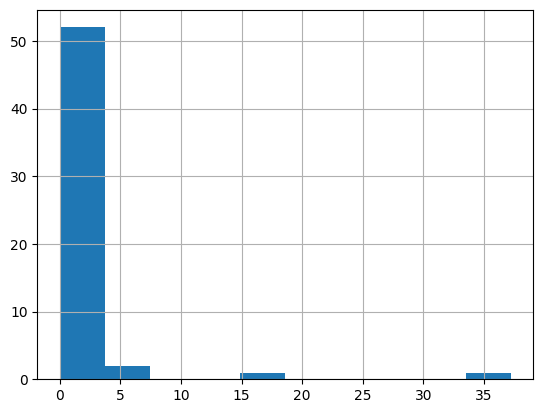

In [430]:
X_test['metab_euc'].hist()

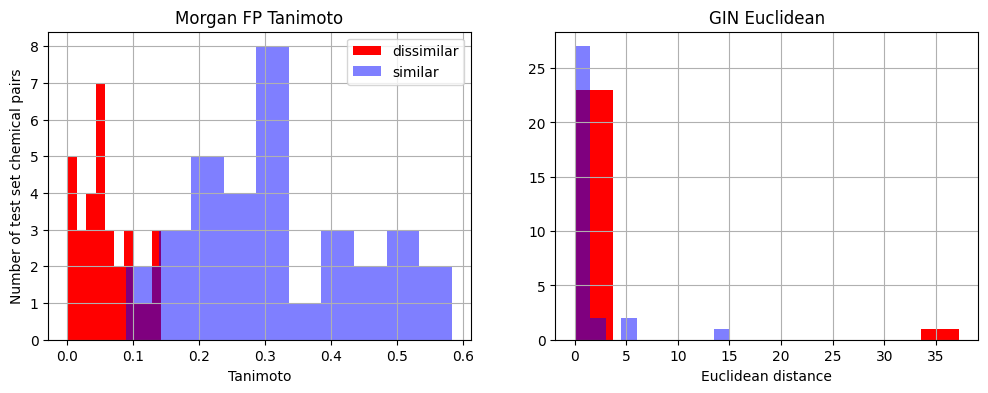

In [432]:
f, axes = plt.subplots(1,2, figsize = (12,4))
X_test[X_test['Label']==1]['metab_euc'].hist(color = 'r', ax=axes[1], label = 'dissimilar')
X_test[X_test['Label']==0]['metab_euc'].hist(color = 'b', alpha = 0.5, ax=axes[1], label = 'similar')
X_test[X_test['Label']==1]['Tanimoto'].hist(color = 'r', ax=axes[0], label = 'dissimilar')
X_test[X_test['Label']==0]['Tanimoto'].hist(color = 'b', alpha = 0.5, ax = axes[0], label = 'similar')
axes[0].set_xlabel('Tanimoto')
axes[0].set_title('Morgan FP Tanimoto')
axes[0].legend()

axes[1].set_title('GIN Euclidean')
axes[1].set_xlabel('Euclidean distance')
axes[0].set_ylabel('Number of test set chemical pairs')
#axes[1].legend()
f.savefig(figures_dir+'testset_MS.png', dpi = 300, bbox_inches = 'tight')